In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Dlnpyutils
from dlnpyutils import utils

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25,'axes.facecolor':'w'})
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d

### TQDM
from tqdm import tqdm_notebook

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def fitz_alebv(wave):
    '''
    Fitzpatrick 1999 extinction law
    '''
    recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])#[:-2]
    alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])#[:-2]

    x=1/wave
    spl = interp1d(recip_anchors,alebv_anchors)
    alebv = spl(x)
    return alebv

leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag']

# APOKASC

In [4]:
# apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
# apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# # 0.659, 0.341 from Asplund et al 2021.
# salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
# salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe))+0.341))*apoafe_err)**2)

In [5]:
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')

# https://iopscience.iop.org/article/10.3847/1538-3881/aba592/pdf

cn = dr17['FPARAM'][:,4]-dr17['FPARAM'][:,5]
dt = dr17['TEFF_SPEC'] - (4400.+552.6*(dr17['LOGG_SPEC']-2.5)-324.6*dr17['FPARAM'][:,3])

rc = dr17[np.where((dr17['FPARAM'][:,1]>2.38)&(dr17['FPARAM'][:,1]<3.5)&
                   (cn>0.04-0.46*dr17['FPARAM'][:,3]-0.0028*dt))]

rgb = dr17[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
                    (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]

# Get rid of stars with any ASPCAP flag
rgb = rgb[np.where((rgb['ASPCAPFLAG']==0))]

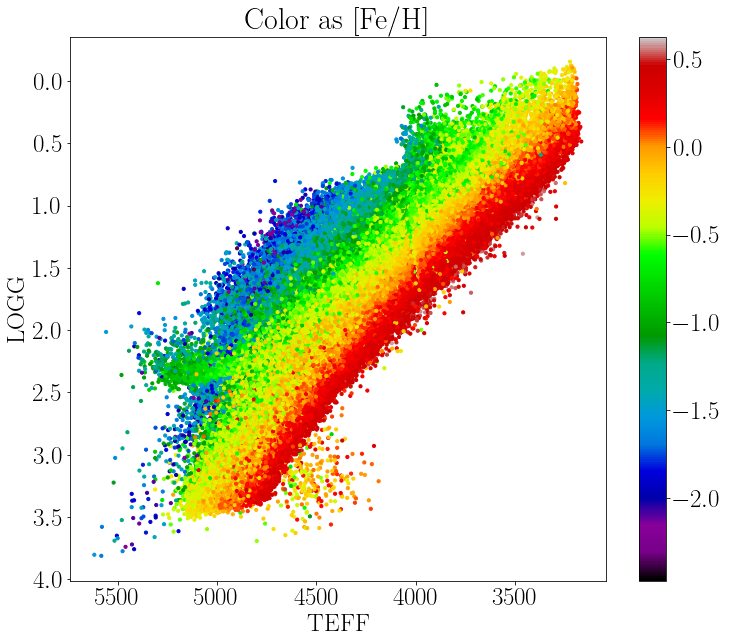

In [6]:
plt.figure(figsize=[12,10])
plt.scatter(rgb['TEFF'],rgb['LOGG'],c=rgb['FE_H'],cmap='nipy_spectral',s=10)
plt.colorbar()

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG');

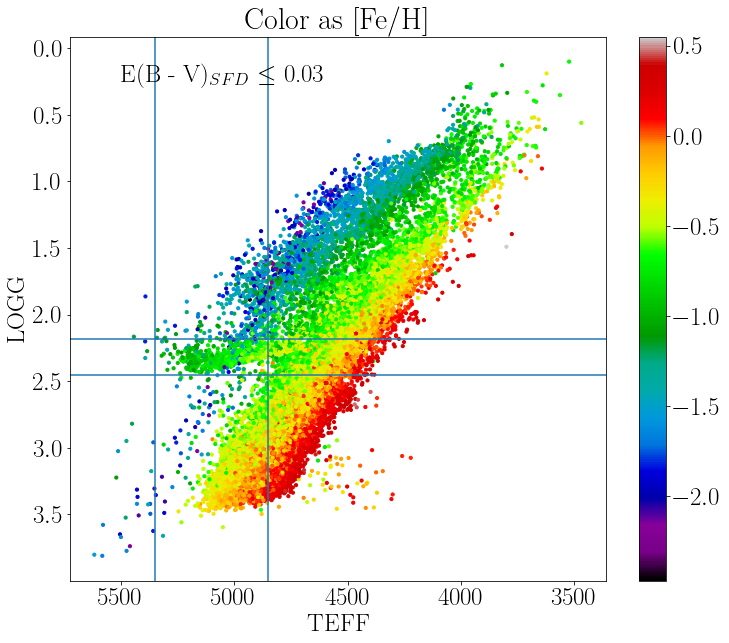

In [7]:
low_ak = np.where((rgb['SFD_EBV']<=0.03)&(rgb['J']-rgb['K']>0.25))

plt.figure(figsize=[12,10])
plt.scatter(rgb['TEFF'][low_ak],rgb['LOGG'][low_ak],c=rgb['FE_H'][low_ak],cmap='nipy_spectral',s=10)
plt.colorbar()

plt.axhline(2.45)
plt.axhline(2.18)

plt.axvline(4850)
plt.axvline(5350)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# plt.text(5500,0.25,r'AK_TARG $\leq$ 0.01')
# plt.text(5500,0.55,r'E(B - V)$_{F99}$ $\leq$ 0.0203')
plt.text(5500,0.25,r'E(B - V)$_{SFD}$ $\leq$ 0.03')

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG');

<ipython-input-8-9cc3ca50668c>:25: RuntimeWarning: invalid value encountered in sqrt
  low_ext_afe_err = np.sqrt(low_ext_rgb['ALPHA_M']**2+low_ext_rgb['M_H']**2-low_ext_rgb['FE_H']**2) # [alpha/Fe] err


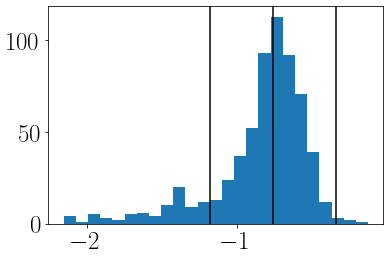

In [8]:
remain_rc_box = np.where((rgb[low_ak]['TEFF']<5350)&(rgb[low_ak]['TEFF']>=4850)&
                         (rgb[low_ak]['LOGG']<2.45)&(rgb[low_ak]['LOGG']>=2.18))

plt.hist(rgb[low_ak][remain_rc_box]['FE_H'],bins=25)

plt.axvline(np.nanmedian(rgb[low_ak][remain_rc_box]['FE_H']),c='k')
plt.axvline(np.nanmedian(rgb[low_ak][remain_rc_box]['FE_H'])+3*mad(rgb[low_ak][remain_rc_box]['FE_H']),c='k')
plt.axvline(np.nanmedian(rgb[low_ak][remain_rc_box]['FE_H'])-3*mad(rgb[low_ak][remain_rc_box]['FE_H']),c='k')

remain_rc_box2 = np.where((rgb[low_ak]['TEFF']<5350)&(rgb[low_ak]['TEFF']>=4850)&
                         (rgb[low_ak]['LOGG']<2.45)&(rgb[low_ak]['LOGG']>=2.18)&
                         (rgb[low_ak]['FE_H']>=np.nanmedian(rgb[low_ak][remain_rc_box]['FE_H'])-
                          3*mad(rgb[low_ak][remain_rc_box]['FE_H'])))

resid_rc_cut = np.where(np.isin(rgb[low_ak]['APOGEE_ID'],rgb[low_ak][remain_rc_box2]['APOGEE_ID'])==False)

### Low Ext
low_ext_rgb = rgb[low_ak][resid_rc_cut] # APOGEE
# low_ext_bperr = bperr[low_ak][resid_rc_cut] # Gaia BP err
# low_ext_gerr = bperr[low_ak][resid_rc_cut] # Gaia G err
# low_ext_rperr = rperr[low_ak][resid_rc_cut] # Gaia RP err

### Salaris Correction
low_ext_afe = low_ext_rgb['ALPHA_M']+low_ext_rgb['M_H']-low_ext_rgb['FE_H'] # [alpha/Fe]
low_ext_afe_err = np.sqrt(low_ext_rgb['ALPHA_M']**2+low_ext_rgb['M_H']**2-low_ext_rgb['FE_H']**2) # [alpha/Fe] err

# 0.659, 0.341 from Asplund et al 2021.
low_ext_salfeh = low_ext_rgb['FE_H']+np.log10(0.659*(10**(low_ext_afe))+0.341)
low_ext_salfeh_err = np.sqrt(low_ext_rgb['FE_H_ERR']**2+
                             ((1-0.341/(0.659*(10**(low_ext_afe))+0.341))*low_ext_afe_err)**2)

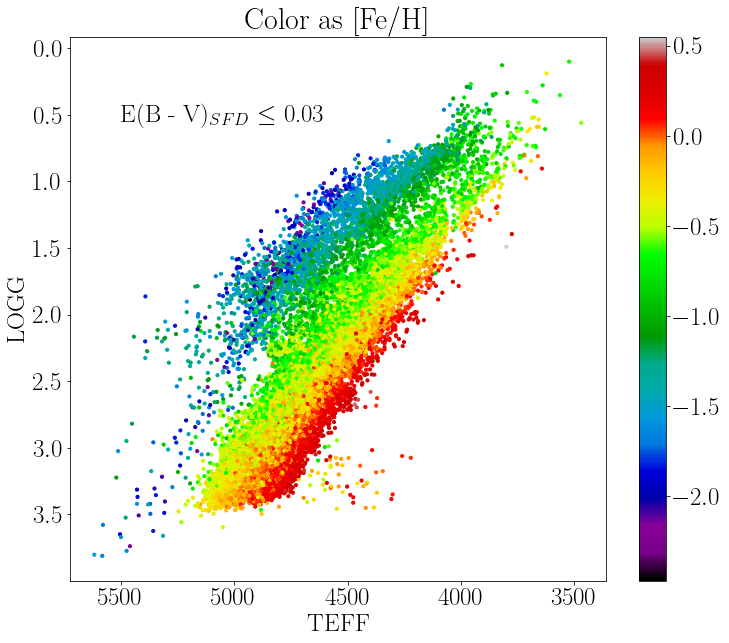

In [9]:
plt.figure(figsize=[12,10])
plt.scatter(low_ext_rgb['TEFF'],low_ext_rgb['LOGG'],c=low_ext_rgb['FE_H'],cmap='nipy_spectral',s=10)
plt.colorbar()

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.text(5500,0.55,r'E(B - V)$_{SFD}$ $\leq$ 0.03')

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG');

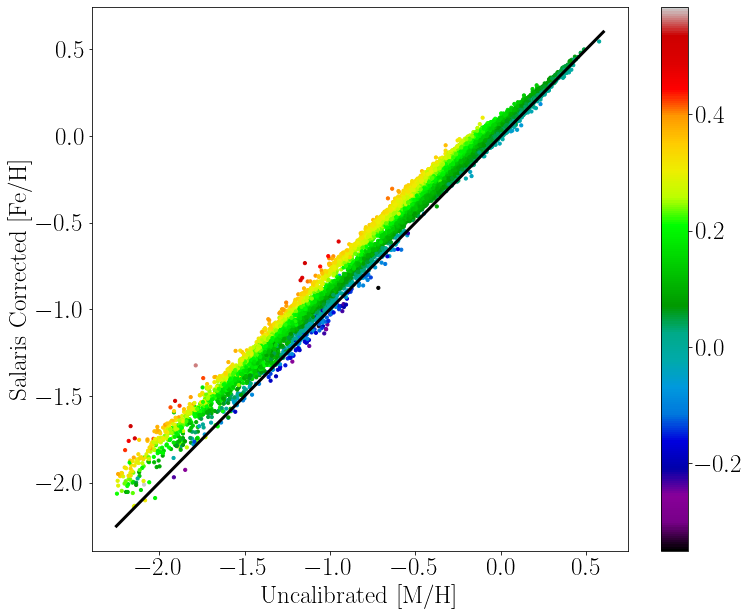

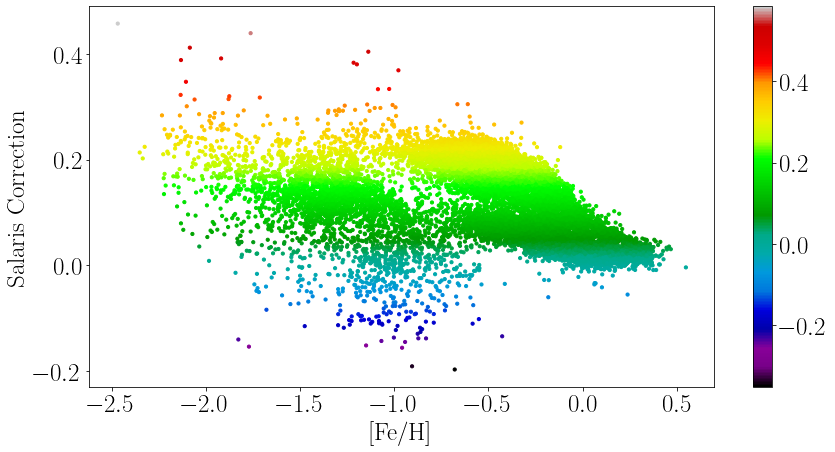

In [10]:
plt.figure(figsize=[12,10])
plt.scatter(low_ext_rgb['FPARAM'][:,3],low_ext_salfeh,c=low_ext_afe,cmap='nipy_spectral',s=10)
plt.colorbar()
plt.plot([-2.25,0.6],[-2.25,0.6],c='k',lw=3.0)
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'Salaris Corrected [Fe/H]')
plt.show()

plt.figure(figsize=[14,7])
plt.scatter(low_ext_rgb['FE_H'],low_ext_salfeh-low_ext_rgb['FE_H'],
            c=low_ext_afe,cmap='nipy_spectral',s=10)
plt.colorbar()
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Salaris Correction')
plt.show()

# Gaia EDR3

In [11]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

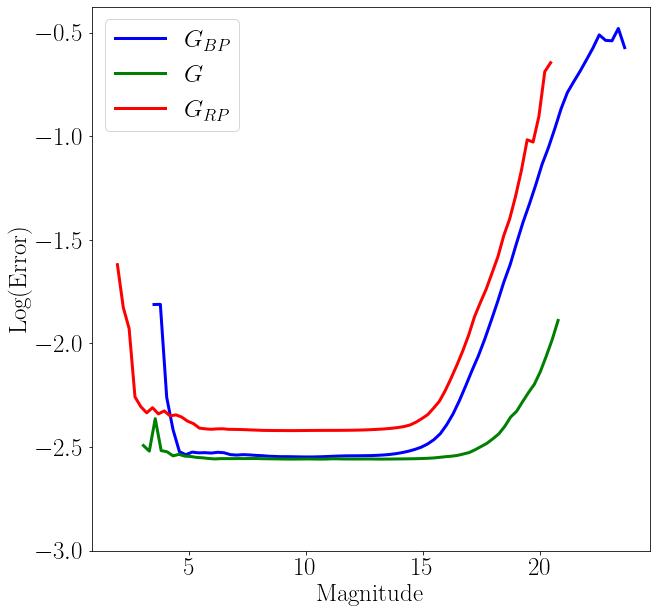

In [12]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = IUS(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
low_ext_bperr = np.nan_to_num(10**bperrfunc(low_ext_rgb['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
low_ext_gerr = np.nan_to_num(10**gerrfunc(low_ext_rgb['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
low_ext_rperr = np.nan_to_num(10**rperrfunc(low_ext_rgb['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

# Calculate the Photometric Teff

In [13]:
def color_teff(obsphot,salfeh,isochrones):
    '''
    Calculate the Teff of a star using it's intrinsic color. This assumes either low extinction or dereddened 
    photometry.
    
    Inputs:
    ------
        obsphot:    6x2 array
                    array of observed photometry and associated errors
        
        salfeh:     float
                    Salaris corrected [Fe/H]
                    
        isochrones: Table
                    Table of isochrones
    
    Outputs:
    -------
        teff:       float
                    photometric teff value calculated
                    
        teff_err:   float
                    error in the calculated 
    '''
    
    color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                             ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
    
    obs_colors = np.delete(obsphot[:,0]-obsphot[1,0],1)
    obs_colors[1:] = -1*obs_colors[1:]
    obs_colors_err = np.delete(np.sqrt(obsphot[:,1]**2+obsphot[1,1]**2),1)
    
    ### Fit color-Teff relation 
    
    # pick out isochrones with same [Fe/H] and cut very young and old ages
    iso = isochrones[np.where(isochrones['MH']==closest(isochrones['MH'],salfeh))]
    iso = iso[np.where((iso['logAge']<np.log10(10**10))&(iso['logAge']>np.log10(0.5*10**9)))]
    
    # calculate the the expect Teff using the five colors
    b_vec = 999999.0*np.ones(5)
    b_vec_deriv = 999999.0*np.ones(5)
    
    for i in range(5):
        # Interpolate the color-Teff relation using a b-spline
        color = (iso[color_labels[i,0]]-iso[color_labels[i,1]])
        logTe = iso['logTe']
        
        bspl = utils.bspline(color,logTe)
        b_vec[i] = bspl(obs_colors[i])
        b_vec_deriv[i] = bspl.derivative()(obs_colors[i])
    
    # Calulate the Teff and associated error
    wgts = np.reciprocal(np.square(np.abs(np.multiply(b_vec_deriv,obs_colors_err))))
    wgts_sum = np.sum(wgts)
    
    lgteff = np.sum(np.multiply(wgts,b_vec))/wgts_sum
    lgteff_err = np.sqrt(1/wgts_sum)
    
    teff = 10**lgteff
    teff_err = np.abs(teff*np.log(10)*lgteff_err)
    
    return np.array([teff,teff_err],dtype='object')

In [14]:
photteffs = 999999.0*np.ones(len(np.squeeze(low_ext_rgb)))
photteffs_err = 999999.0*np.ones(len(np.squeeze(low_ext_rgb)))

for i in tqdm_notebook(range(len(np.squeeze(low_ext_rgb)))):

    op = np.array([[low_ext_rgb['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    low_ext_rgb['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
                    low_ext_rgb['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    low_ext_rgb['J'][i],low_ext_rgb['H'][i],
                    low_ext_rgb['K'][i]],
                   [low_ext_bperr[i],low_ext_gerr[i],low_ext_rperr[i],
                    low_ext_rgb['J_ERR'][i],low_ext_rgb['H_ERR'][i],
                    low_ext_rgb['K_ERR'][i]]]).T
    
    photteffs[i], photteffs_err[i] = color_teff(op,low_ext_salfeh[i],massive)

<ipython-input-14-030923012225>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(low_ext_rgb)))):


  0%|          | 0/19447 [00:00<?, ?it/s]

In [16]:
### save ages to fits file
from astropy.table import Table, Column

cname = Column(low_ext_rgb['APOGEE_ID'], name='NAME')
cteff = Column(photteffs,name='PHOTTEFF')
cteff_err = Column(photteffs_err,name='PHOTTEFF_ERR')


tefftable = Table([cname,cteff,cteff_err])
# tefftable.write('low_ext_rgb_photteff_PARSEC36_EDR3.fits', format='fits')#, overwrite=True)

pteff = fits.getdata('low_ext_rgb_photteff_PARSEC36_EDR3.fits')

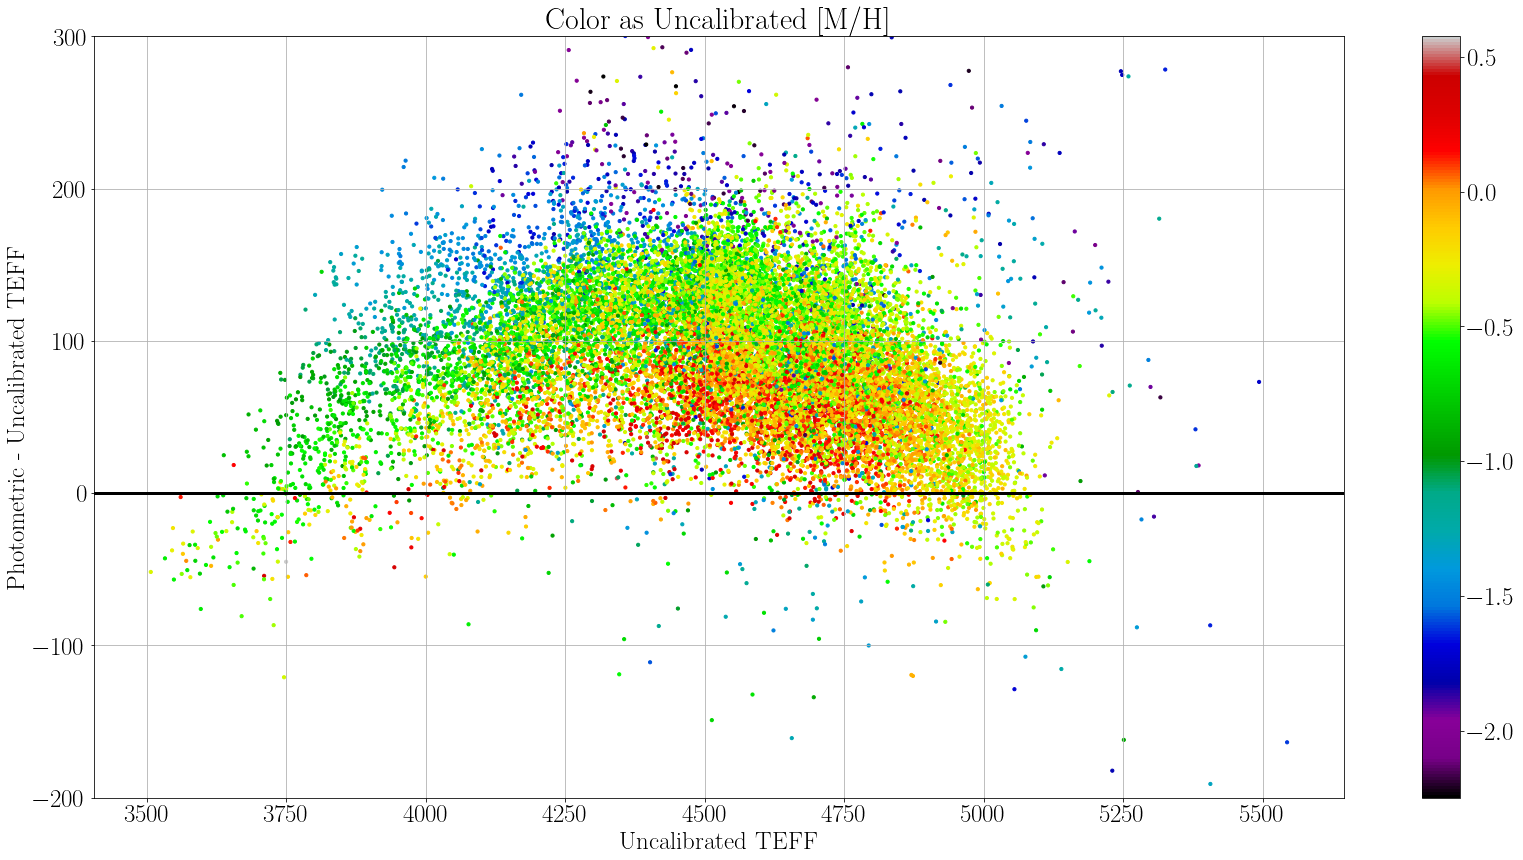

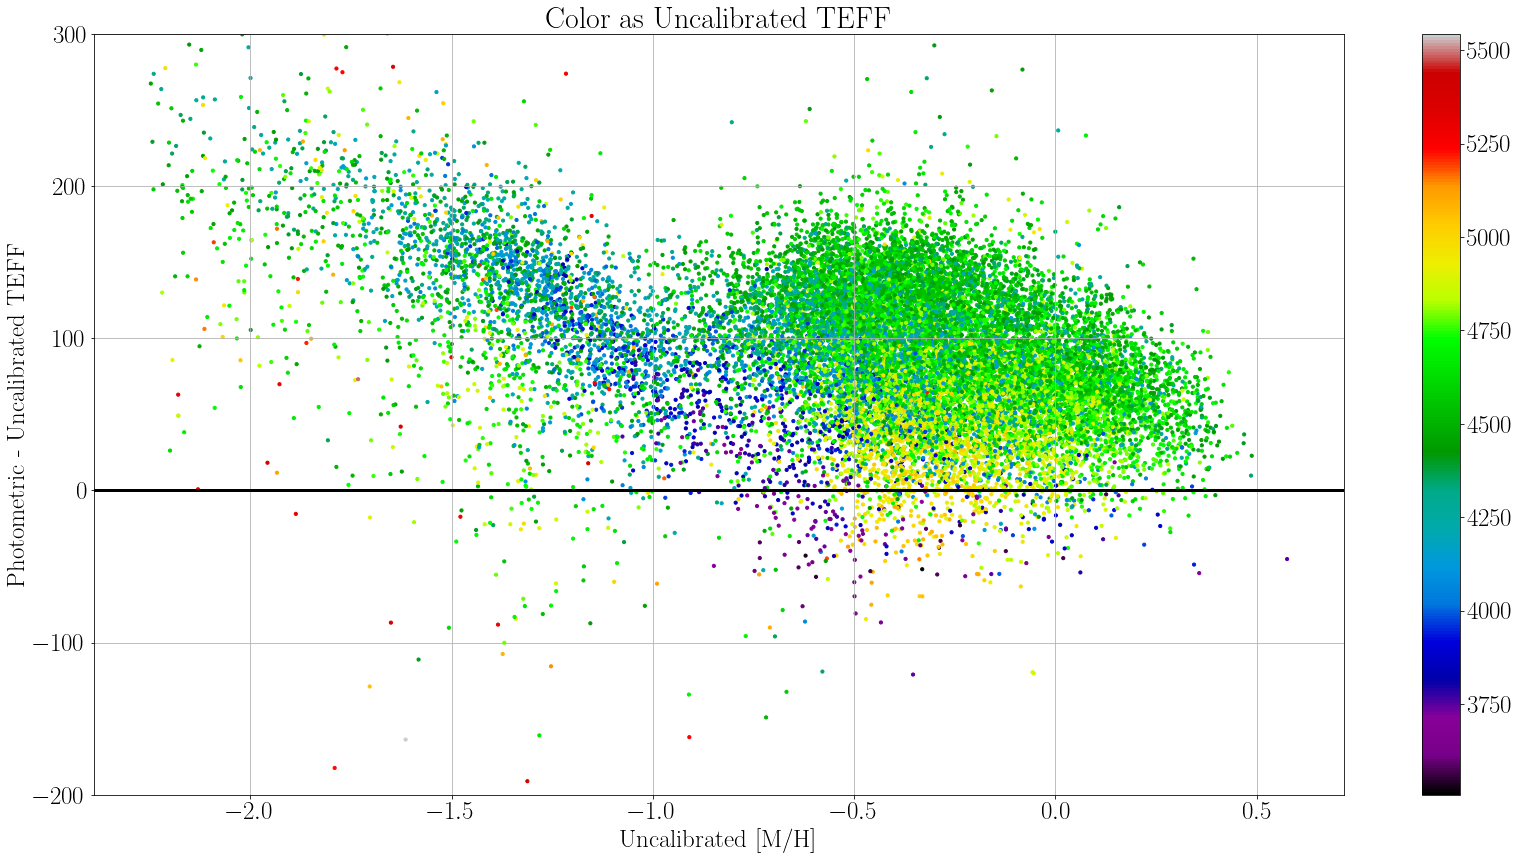

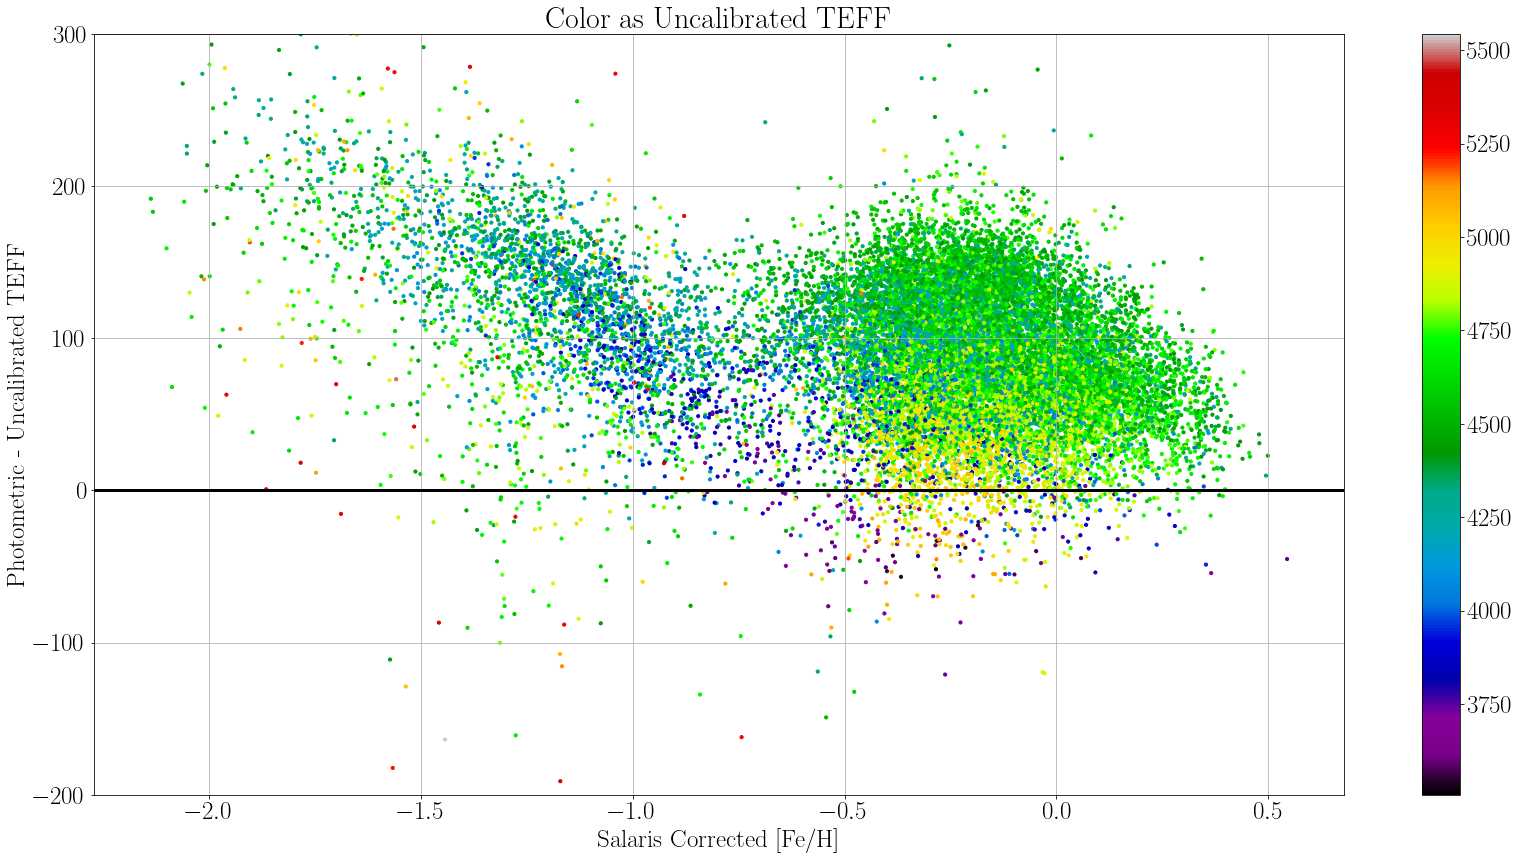

In [17]:
plt.figure(figsize=[28,14])
plt.scatter(low_ext_rgb['FPARAM'][:,0],pteff['PHOTTEFF']-low_ext_rgb['FPARAM'][:,0],
            c=low_ext_rgb['FPARAM'][:,3],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-200,300)
plt.grid()
plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated TEFF')
plt.ylabel(r'Photometric - Uncalibrated TEFF')
plt.show()

plt.figure(figsize=[28,14])
plt.scatter(low_ext_rgb['FPARAM'][:,3],pteff['PHOTTEFF']-low_ext_rgb['FPARAM'][:,0],
            c=low_ext_rgb['FPARAM'][:,0],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-200,300)
plt.grid()
plt.title(r'Color as Uncalibrated TEFF')
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'Photometric - Uncalibrated TEFF')
plt.show()

plt.figure(figsize=[28,14])
plt.scatter(low_ext_salfeh,pteff['PHOTTEFF']-low_ext_rgb['FPARAM'][:,0],
            c=low_ext_rgb['FPARAM'][:,0],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-200,300)
plt.grid()
plt.title(r'Color as Uncalibrated TEFF')
plt.xlabel(r'Salaris Corrected [Fe/H]')
plt.ylabel(r'Photometric - Uncalibrated TEFF')
plt.show()

# Teff Spline

ValueError: could not broadcast input array from shape (41,) into shape (39,)

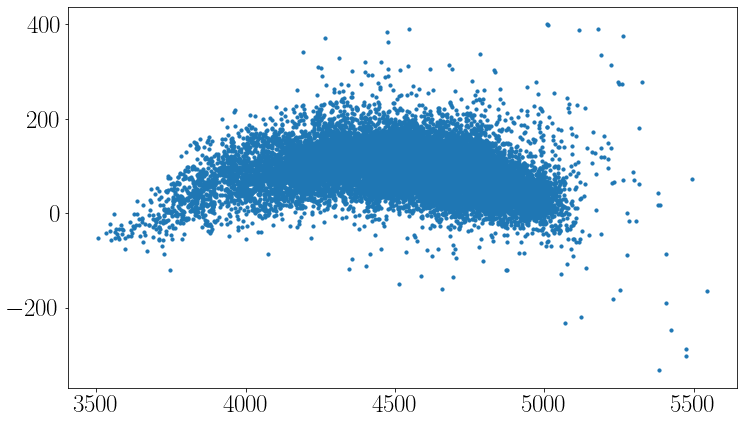

In [18]:
finptf = np.where((np.isfinite(low_ext_rgb['FPARAM'][:,0])==True)&
                  (np.isfinite(low_ext_rgb['FPARAM'][:,3])==True)&(np.isfinite(pteff['PHOTTEFF'])==True))

medsptf,edgsptf,_ = binned_statistic(low_ext_rgb['FPARAM'][:,0][finptf],
                               (pteff['PHOTTEFF']-low_ext_rgb['FPARAM'][:,0])[finptf],bins=50)

censptf = edgsptf[:-1]+np.nanmedian(np.diff(edgsptf))/2.

plt.figure(figsize=[12,7])
plt.scatter(low_ext_rgb['FPARAM'][:,0],pteff['PHOTTEFF']-low_ext_rgb['FPARAM'][:,0],s=10)
plt.hlines(medsptf[:-11],edgsptf[:-1][:-11],edgsptf[1:][:-9], colors='r', lw=5.)
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-200,300)
plt.grid()
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'Photometric - Uncalibrated Teff');

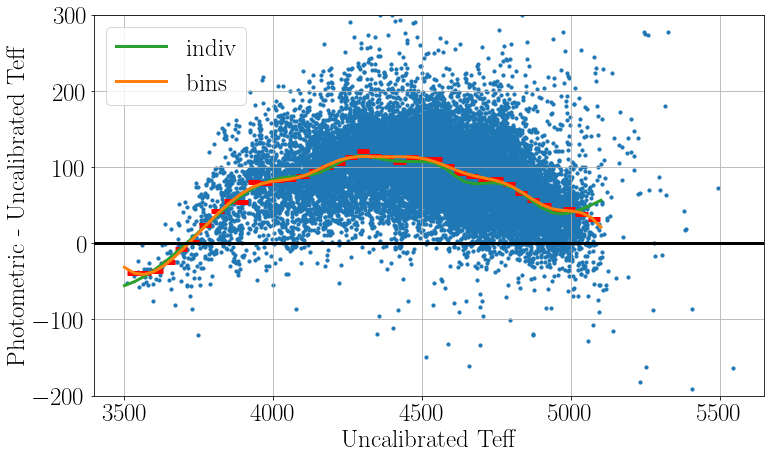

3.2379543731340164
27.8075626298687


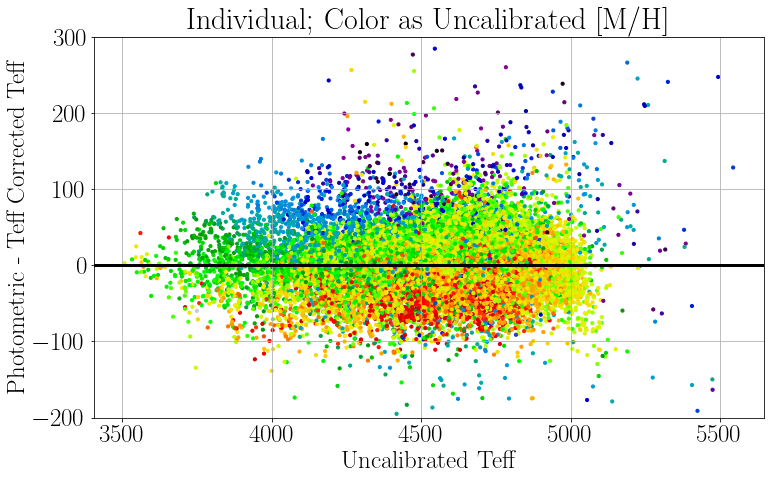

-0.4600077069244435
27.69684444086488


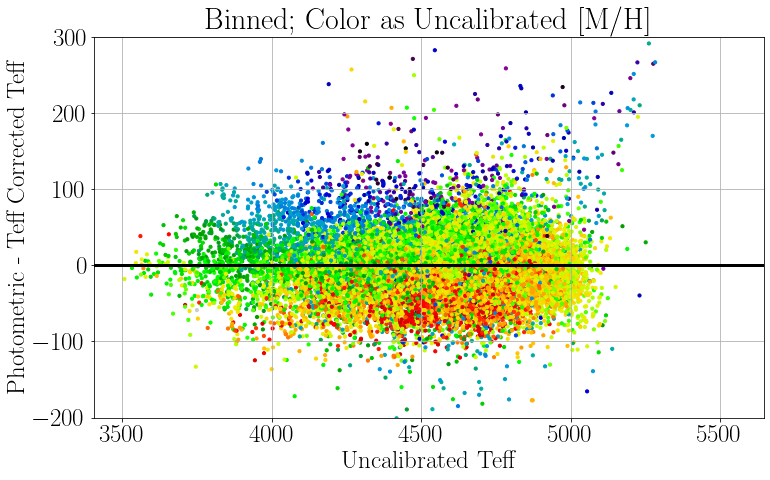

In [20]:
finptf2 = np.where((np.isfinite(censptf[:-11])==True)&(np.isfinite(medsptf[:-11])==True))

tcal_bin_spl = utils.bspline(censptf[:-11][finptf2],medsptf[:-11][finptf2],extrapolate=True)
tcal_ind_spl = utils.bspline(low_ext_rgb['FPARAM'][:,0][finptf],
                             (pteff['PHOTTEFF']-low_ext_rgb['FPARAM'][:,0])[finptf],
                             extrapolate=True)

###
plt.figure(figsize=[12,7])
plt.scatter(low_ext_rgb['FPARAM'][:,0],pteff['PHOTTEFF']-low_ext_rgb['FPARAM'][:,0],s=10)
plt.hlines(medsptf[finptf2],edgsptf[:-1][finptf2],edgsptf[1:][finptf2], colors='r', lw=5.)

x_teffs = np.linspace(3500,5100)

# plt.plot(np.linspace(np.nanmin(low_ext_rgb['FPARAM'][:,0]),np.nanmax(low_ext_rgb['FPARAM'][:,0])),
#          tcal_ind_spl(np.linspace(np.nanmin(low_ext_rgb['FPARAM'][:,0]),np.nanmax(low_ext_rgb['FPARAM'][:,0]))),
#          c='tab:green',lw=3.0,label='indiv')

# plt.plot(np.linspace(np.nanmin(low_ext_rgb['FPARAM'][:,0]),np.nanmax(low_ext_rgb['FPARAM'][:,0])),
#          tcal_bin_spl(np.linspace(np.nanmin(low_ext_rgb['FPARAM'][:,0]),np.nanmax(low_ext_rgb['FPARAM'][:,0]))),
#          lw=3.0,c='tab:orange',label='bins')

plt.plot(x_teffs,tcal_ind_spl(x_teffs),c='tab:green',lw=3.0,label='indiv')

plt.plot(x_teffs,tcal_bin_spl(x_teffs),lw=3.0,c='tab:orange',label='bins')

plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'Photometric - Uncalibrated Teff')

plt.legend()

plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-200,300)
plt.grid()
plt.show()

###
print(np.nanmedian(pteff['PHOTTEFF']-(tcal_ind_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])))
print(mad(pteff['PHOTTEFF']-(tcal_ind_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])))
plt.figure(figsize=[12,7])
plt.scatter(low_ext_rgb['FPARAM'][:,0],
            pteff['PHOTTEFF']-(tcal_ind_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0]),
            c=low_ext_rgb['FPARAM'][:,3],s=10,cmap='nipy_spectral')
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-200,300)
plt.grid()
plt.title(r'Individual; Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'Photometric - Teff Corrected Teff')
plt.show()

###
print(np.nanmedian(pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])))
print(mad(pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])))
plt.figure(figsize=[12,7])
plt.scatter(low_ext_rgb['FPARAM'][:,0],
            pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0]),
            c=low_ext_rgb['FPARAM'][:,3],s=10,cmap='nipy_spectral')
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-200,300)
plt.grid()
plt.title(r'Binned; Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'Photometric - Teff Corrected Teff')
plt.show()

In [21]:
print('Individual Spline Knots')
np.array([tcal_ind_spl.tck[0],tcal_ind_spl.tck[1]]).T

Individual Spline Knots


array([[3507.10009766,  -54.62501183],
       [3507.10009766,  -32.37930056],
       [3507.10009766,  100.00035307],
       [3507.10009766,   83.27121343],
       [4007.3363592 ,  122.49206945],
       [4158.47270064,  107.38708765],
       [4270.00909979,  107.2576406 ],
       [4380.04549893,  108.06309346],
       [4476.78169389,   72.57546092],
       [4561.61829723,   83.01634994],
       [4646.45450107,   72.61418685],
       [4733.09099787,  -32.85548821],
       [4822.02729936,  255.58873865],
       [4922.46360085, -292.20887984],
       [5543.79980469,    0.        ],
       [5543.79980469,    0.        ],
       [5543.79980469,    0.        ],
       [5543.79980469,    0.        ]])

In [22]:
print('Binned Spline Knots')
np.round(np.array([tcal_bin_spl.tck[0],tcal_bin_spl.tck[1]]).T,3)

Binned Spline Knots


array([[3527.467,  -38.492],
       [3527.467,  -46.418],
       [3527.467,  -22.575],
       [3527.467,   40.55 ],
       [3668.184,   85.291],
       [3808.902,   80.168],
       [3949.619,  117.604],
       [4090.337,  111.846],
       [4231.054,  116.507],
       [4371.771,   85.972],
       [4512.489,   84.143],
       [4653.206,   33.936],
       [4793.924,   46.761],
       [4934.642,   31.483],
       [5075.358,    0.   ],
       [5075.358,    0.   ],
       [5075.358,    0.   ],
       [5075.358,    0.   ]])

In [23]:
tcal_bin_spl.tck

(array([3527.46704102, 3527.46704102, 3527.46704102, 3527.46704102,
        3668.18445934, 3808.90189986, 3949.61929599, 4090.33695845,
        4231.05442116, 4371.77148438, 4512.48925781, 4653.2064098 ,
        4793.92382812, 4934.64160156, 5075.35839844, 5075.35839844,
        5075.35839844, 5075.35839844]),
 array([-38.49191624, -46.41835173, -22.57478812,  40.54969913,
         85.29094276,  80.16775098, 117.60380973, 111.84626579,
        116.50694671,  85.97181951,  84.1434932 ,  33.93551731,
         46.76054409,  31.48308843,   0.        ,   0.        ,
          0.        ,   0.        ]),
 3)

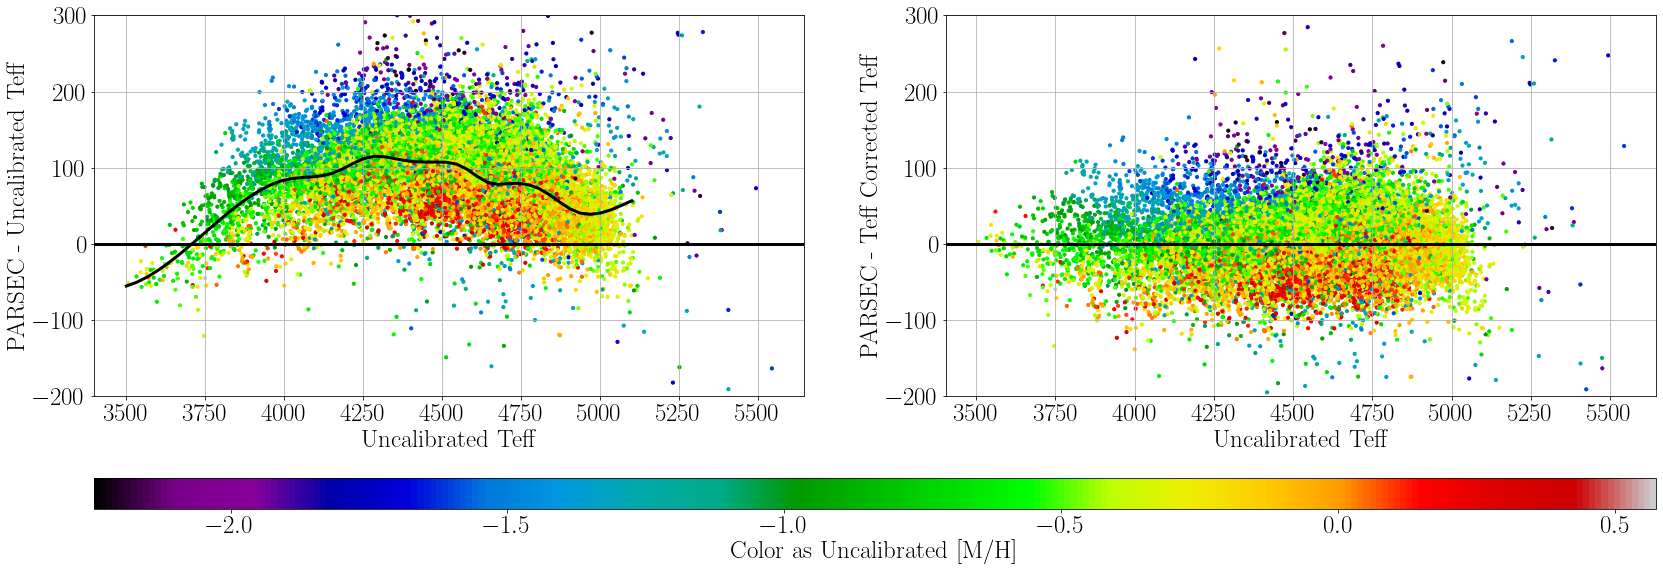

In [24]:
### Individual
fig,ax = plt.subplots(1,2,figsize=[28,10])

ax[0].scatter(low_ext_rgb['FPARAM'][:,0],pteff['PHOTTEFF']-low_ext_rgb['FPARAM'][:,0],
              c=low_ext_rgb['FPARAM'][:,3],s=10,cmap='nipy_spectral')

# ax[0].plot(censptf[finptf2],tcal_ind_spl(censptf[finptf2]),c='k',lw=3.0)
ax[0].plot(x_teffs,tcal_ind_spl(x_teffs),c='k',lw=3.0)
ax[0].axhline(0.0,c='k',lw=3.0)
ax[0].set_ylim(-200,300)
ax[0].grid()
ax[0].set_xlabel(r'Uncalibrated Teff')
ax[0].set_ylabel(r'PARSEC - Uncalibrated Teff')

###
im = ax[1].scatter(low_ext_rgb['FPARAM'][:,0],
            pteff['PHOTTEFF']-(tcal_ind_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0]),
            c=low_ext_rgb['FPARAM'][:,3],s=10,cmap='nipy_spectral')

ax[1].axhline(0.0,c='k',lw=3.0)
ax[1].set_ylim(-200,300)
ax[1].grid()
ax[1].set_xlabel(r'Uncalibrated Teff')
ax[1].set_ylabel(r'PARSEC - Teff Corrected Teff')

cbar = fig.colorbar(im,orientation='horizontal',aspect=50,ax=ax.ravel().tolist())
cbar.set_label('Color as Uncalibrated [M/H]',labelpad=1)

plt.savefig('../plots/teff_teff_ind_spline.pdf',dpi=300,bbox_inches='tight')
plt.show()

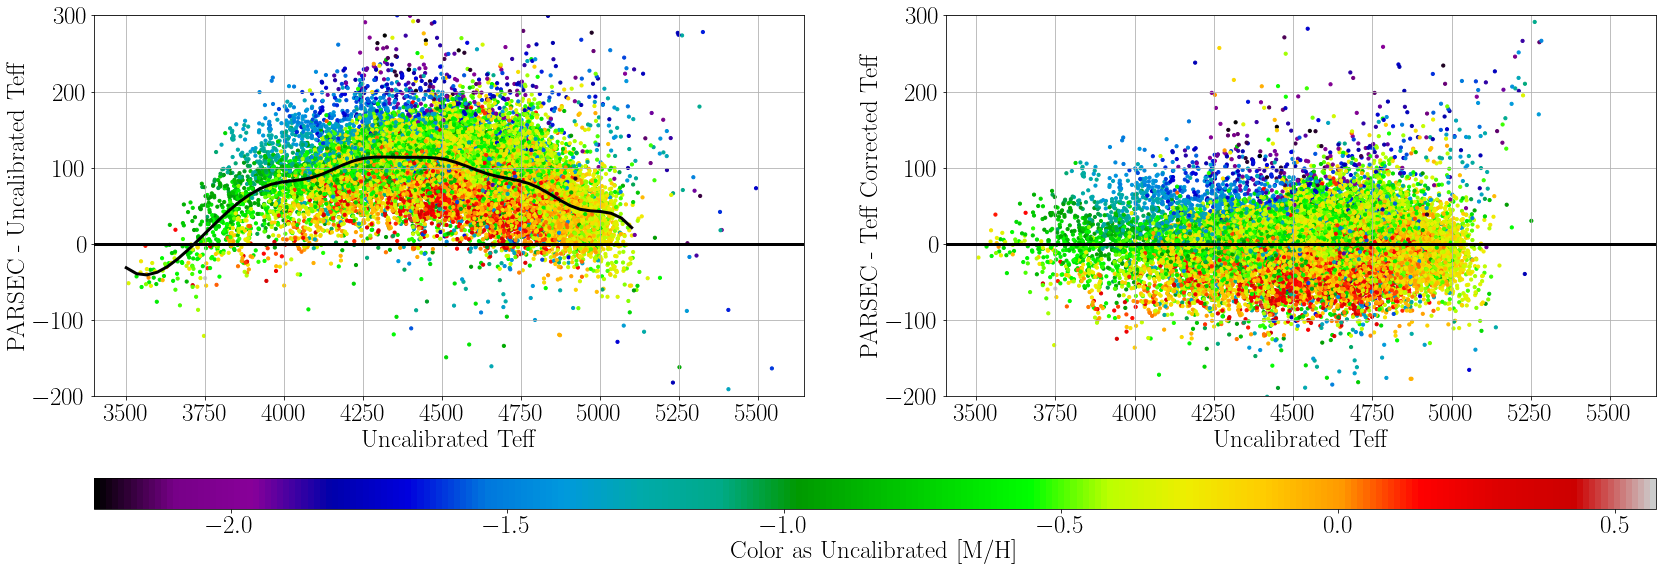

In [36]:
### Binned
fig,ax = plt.subplots(1,2,figsize=[28,10])

ax[0].scatter(low_ext_rgb['FPARAM'][:,0],pteff['PHOTTEFF']-low_ext_rgb['FPARAM'][:,0],
              c=low_ext_rgb['FPARAM'][:,3],s=10,cmap='nipy_spectral')

# ax[0].plot(censptf[finptf2],tcal_bin_spl(censptf[finptf2]),c='k',lw=3.0)
ax[0].plot(x_teffs,tcal_bin_spl(x_teffs),c='k',lw=3.0)
ax[0].axhline(0.0,c='k',lw=3.0)
ax[0].set_ylim(-200,300)
ax[0].grid()
ax[0].set_xlabel(r'Uncalibrated Teff')
ax[0].set_ylabel(r'PARSEC - Uncalibrated Teff')

###
im = ax[1].scatter(low_ext_rgb['FPARAM'][:,0],
            pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0]),
            c=low_ext_rgb['FPARAM'][:,3],s=10,cmap='nipy_spectral')

ax[1].axhline(0.0,c='k',lw=3.0)
ax[1].set_ylim(-200,300)
ax[1].grid()
ax[1].set_xlabel(r'Uncalibrated Teff')
ax[1].set_ylabel(r'PARSEC - Teff Corrected Teff')

cbar = fig.colorbar(im,orientation='horizontal',aspect=50,ax=ax.ravel().tolist())
cbar.set_label('Color as Uncalibrated [M/H]',labelpad=1)

plt.savefig('../plots/teff_teff_bin_spline.png',dpi=300,bbox_inches='tight')
plt.show()

# [M/H] Spline

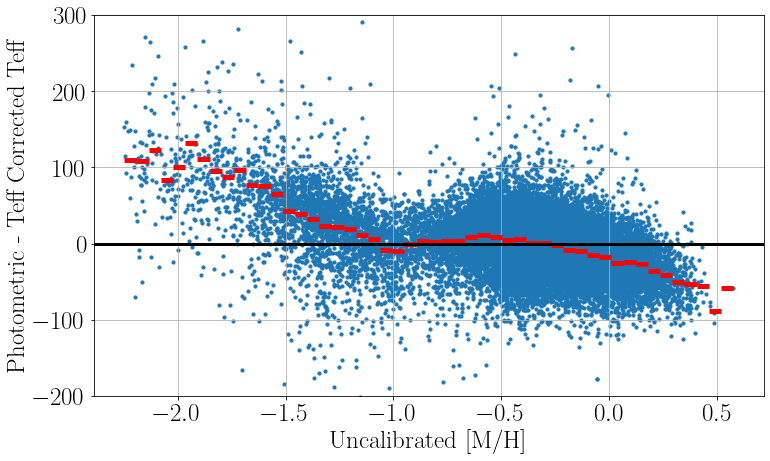

In [26]:
finpmh = np.where((np.isfinite(low_ext_rgb['FPARAM'][:,0])==True)&
                  (np.isfinite(low_ext_rgb['FPARAM'][:,3])==True)&(np.isfinite(pteff['PHOTTEFF'])==True))

medspmh,edgspmh,_ = binned_statistic(low_ext_rgb['FPARAM'][:,3][finpmh],
                               (pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0]))[finpmh],bins=50)

censpmh = edgspmh[:-1]+np.nanmedian(np.diff(edgspmh))/2.

plt.figure(figsize=[12,7])
plt.scatter(low_ext_rgb['FPARAM'][:,3],pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0]),s=10)
plt.hlines(medspmh,edgspmh[:-1],edgspmh[1:], colors='r', lw=5.)
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-200,300)
plt.grid()
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'Photometric - Teff Corrected Teff');

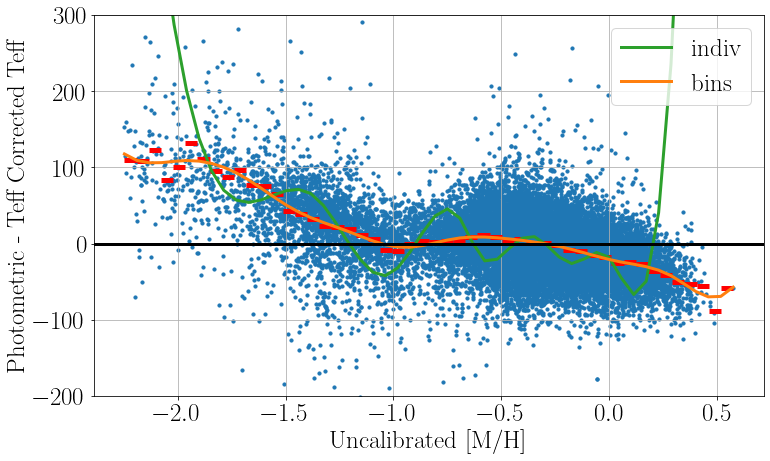

0.6633796149288003
23.46954250002467


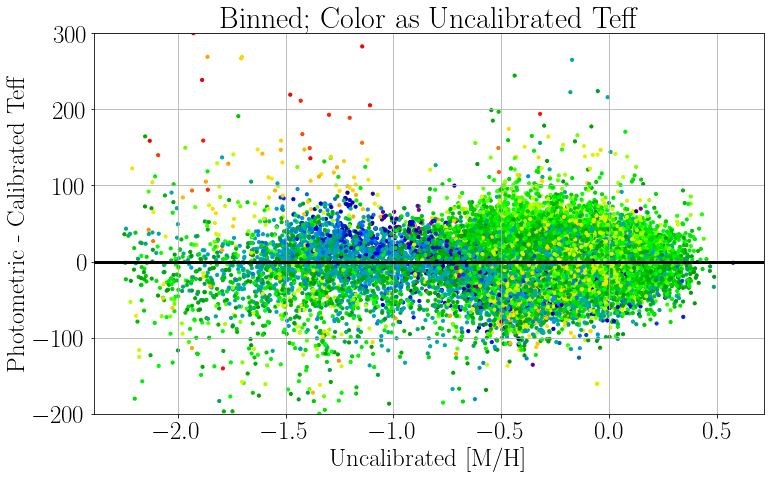

5.628776518537585
28.20684947597666


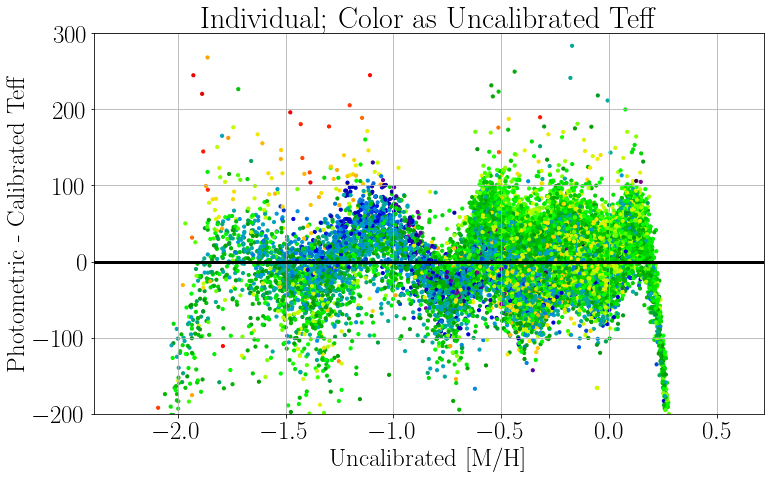

In [27]:
finpmh2 = np.where((np.isfinite(censpmh)==True)&(np.isfinite(medspmh)==True))

mcal_bin_spl = utils.bspline(censpmh[finpmh2],medspmh[finpmh2],extrapolate=True)
mcal_ind_spl = utils.bspline(low_ext_rgb['FPARAM'][:,3][finpmh2],
                             (pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0]))[finpmh2],
                             extrapolate=True)

###
plt.figure(figsize=[12,7])
plt.scatter(low_ext_rgb['FPARAM'][:,3],(pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])),s=10)
plt.hlines(medspmh[finpmh2],edgspmh[:-1][finpmh2],edgspmh[1:][finpmh2], colors='r', lw=5.)

plt.plot(np.linspace(np.nanmin(low_ext_rgb['FPARAM'][:,3]),np.nanmax(low_ext_rgb['FPARAM'][:,3])),
         mcal_ind_spl(np.linspace(np.nanmin(low_ext_rgb['FPARAM'][:,3]),np.nanmax(low_ext_rgb['FPARAM'][:,3]))),
         c='tab:green',lw=3.0,label='indiv')

plt.plot(np.linspace(np.nanmin(low_ext_rgb['FPARAM'][:,3]),np.nanmax(low_ext_rgb['FPARAM'][:,3])),
         mcal_bin_spl(np.linspace(np.nanmin(low_ext_rgb['FPARAM'][:,3]),np.nanmax(low_ext_rgb['FPARAM'][:,3]))),
         lw=3.0,c='tab:orange',label='bins')

plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'Photometric - Teff Corrected Teff')

plt.legend()

plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-200,300)
plt.grid()
plt.show()

###
print(np.nanmedian(pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])-
                   (mcal_bin_spl(low_ext_rgb['FPARAM'][:,3]))))
print(mad(pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])-
          (mcal_bin_spl(low_ext_rgb['FPARAM'][:,3]))))
plt.figure(figsize=[12,7])
plt.scatter(low_ext_rgb['FPARAM'][:,3],
            pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])-
            (mcal_bin_spl(low_ext_rgb['FPARAM'][:,3])),
            c=low_ext_rgb['FPARAM'][:,0],s=10,cmap='nipy_spectral')
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-200,300)
plt.grid()
plt.title(r'Binned; Color as Uncalibrated Teff')
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'Photometric - Calibrated Teff')
plt.show()

###
print(np.nanmedian(pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])-
                   (mcal_ind_spl(low_ext_rgb['FPARAM'][:,3]))))
print(mad(pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])-
          (mcal_ind_spl(low_ext_rgb['FPARAM'][:,3]))))
plt.figure(figsize=[12,7])
plt.scatter(low_ext_rgb['FPARAM'][:,3],
            pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])-
            (mcal_ind_spl(low_ext_rgb['FPARAM'][:,3])),
            c=low_ext_rgb['FPARAM'][:,0],s=10,cmap='nipy_spectral')
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-200,300)
plt.grid()
plt.title(r'Individual; Color as Uncalibrated Teff')
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'Photometric - Calibrated Teff')
plt.show()

In [28]:
print('Individual Spline Knots')
np.array([mcal_ind_spl.tck[0],mcal_ind_spl.tck[1]]).T

Individual Spline Knots


array([[-1.72819996e+00,  5.71287324e+01],
       [-1.72819996e+00,  4.20198097e+01],
       [-1.72819996e+00,  1.33787836e+02],
       [-1.72819996e+00, -9.02178838e+01],
       [-1.37220909e+00,  1.20299917e+01],
       [-1.03343632e+00,  7.58695300e+01],
       [-8.80524543e-01, -3.65749889e+01],
       [-7.03018188e-01, -1.54785357e+01],
       [-5.81012748e-01,  1.05657924e+01],
       [-4.97860911e-01,  1.03100435e+01],
       [-3.91520901e-01, -5.31222486e+01],
       [-3.37714539e-01,  2.95595492e+01],
       [-1.72340004e-01, -1.06175031e+02],
       [-5.54281871e-03, -4.03404331e+01],
       [ 1.81710005e-01,  0.00000000e+00],
       [ 1.81710005e-01,  0.00000000e+00],
       [ 1.81710005e-01,  0.00000000e+00],
       [ 1.81710005e-01,  0.00000000e+00]])

In [29]:
print('Individual Spline Knots')
np.array([mcal_ind_spl.tck[0],mcal_ind_spl.tck[1]]).T

Individual Spline Knots


array([[-1.72819996e+00,  5.71287324e+01],
       [-1.72819996e+00,  4.20198097e+01],
       [-1.72819996e+00,  1.33787836e+02],
       [-1.72819996e+00, -9.02178838e+01],
       [-1.37220909e+00,  1.20299917e+01],
       [-1.03343632e+00,  7.58695300e+01],
       [-8.80524543e-01, -3.65749889e+01],
       [-7.03018188e-01, -1.54785357e+01],
       [-5.81012748e-01,  1.05657924e+01],
       [-4.97860911e-01,  1.03100435e+01],
       [-3.91520901e-01, -5.31222486e+01],
       [-3.37714539e-01,  2.95595492e+01],
       [-1.72340004e-01, -1.06175031e+02],
       [-5.54281871e-03, -4.03404331e+01],
       [ 1.81710005e-01,  0.00000000e+00],
       [ 1.81710005e-01,  0.00000000e+00],
       [ 1.81710005e-01,  0.00000000e+00],
       [ 1.81710005e-01,  0.00000000e+00]])

In [30]:
print('Binned Spline Knots')
np.array([mcal_bin_spl.tck[0],mcal_bin_spl.tck[1]]).T

Binned Spline Knots


array([[-2.21858025e+00,  1.12848696e+02],
       [-2.21858025e+00,  1.00546777e+02],
       [-2.21858025e+00,  1.15992357e+02],
       [-2.21858025e+00,  9.79509398e+01],
       [-1.96716837e+00,  3.87315323e+01],
       [-1.71575650e+00,  1.86357031e+01],
       [-1.46434463e+00, -1.50821811e+01],
       [-1.21293276e+00,  1.21509274e+01],
       [-9.61520889e-01,  6.69424869e+00],
       [-7.10109077e-01, -2.90025110e+00],
       [-4.58697175e-01, -2.68067104e+01],
       [-2.07285313e-01, -3.13392475e+01],
       [ 4.41265486e-02, -8.25826363e+01],
       [ 2.95538409e-01, -6.49082047e+01],
       [ 5.46950281e-01,  0.00000000e+00],
       [ 5.46950281e-01,  0.00000000e+00],
       [ 5.46950281e-01,  0.00000000e+00],
       [ 5.46950281e-01,  0.00000000e+00]])

In [31]:
print('Binned Spline Knots')
np.round(np.array([tcal_bin_spl.tck[0],tcal_bin_spl.tck[1],mcal_bin_spl.tck[0],mcal_bin_spl.tck[1]]).T,3)

Binned Spline Knots


array([[ 3.527467e+03, -3.849200e+01, -2.219000e+00,  1.128490e+02],
       [ 3.527467e+03, -4.641800e+01, -2.219000e+00,  1.005470e+02],
       [ 3.527467e+03, -2.257500e+01, -2.219000e+00,  1.159920e+02],
       [ 3.527467e+03,  4.055000e+01, -2.219000e+00,  9.795100e+01],
       [ 3.668184e+03,  8.529100e+01, -1.967000e+00,  3.873200e+01],
       [ 3.808902e+03,  8.016800e+01, -1.716000e+00,  1.863600e+01],
       [ 3.949619e+03,  1.176040e+02, -1.464000e+00, -1.508200e+01],
       [ 4.090337e+03,  1.118460e+02, -1.213000e+00,  1.215100e+01],
       [ 4.231054e+03,  1.165070e+02, -9.620000e-01,  6.694000e+00],
       [ 4.371771e+03,  8.597200e+01, -7.100000e-01, -2.900000e+00],
       [ 4.512489e+03,  8.414300e+01, -4.590000e-01, -2.680700e+01],
       [ 4.653206e+03,  3.393600e+01, -2.070000e-01, -3.133900e+01],
       [ 4.793924e+03,  4.676100e+01,  4.400000e-02, -8.258300e+01],
       [ 4.934642e+03,  3.148300e+01,  2.960000e-01, -6.490800e+01],
       [ 5.075358e+03,  0.000000e+

In [32]:
# 3527.467& -38.492& -2.219&  112.849\\
# 3527.467& -46.418& -2.219&  100.547\\
# 3527.467& -22.575& -2.219&  115.992\\
# 3527.467&  40.550& -2.219&  97.951\\
# 3668.184&  85.291& -1.967&  38.732\\
# 3808.902&  80.168& -1.716&  18.636\\
# 3949.619&  117.604& -1.464& -15.082\\
# 4090.337&  111.846& -1.213&  12.151\\
# 4231.054&  116.507& -0.962&  6.694\\
# 4371.771&  85.972& -0.710& -2.900\\
# 4512.489&  84.143& -0.459& -26.807\\
# 4653.206&  33.936& -0.207& -31.339\\
# 4793.924&  46.761&  0.044& -82.583\\
# 4934.642&  31.483&  0.296& -64.908\\
# 5075.358&  0.000&  0.547&  0.000\\
# 5075.358&  0.000&  0.547&  0.000\\
# 5075.358&  0.000&  0.547&  0.000\\
# 5075.358&  0.000&  0.547&  0.000\\

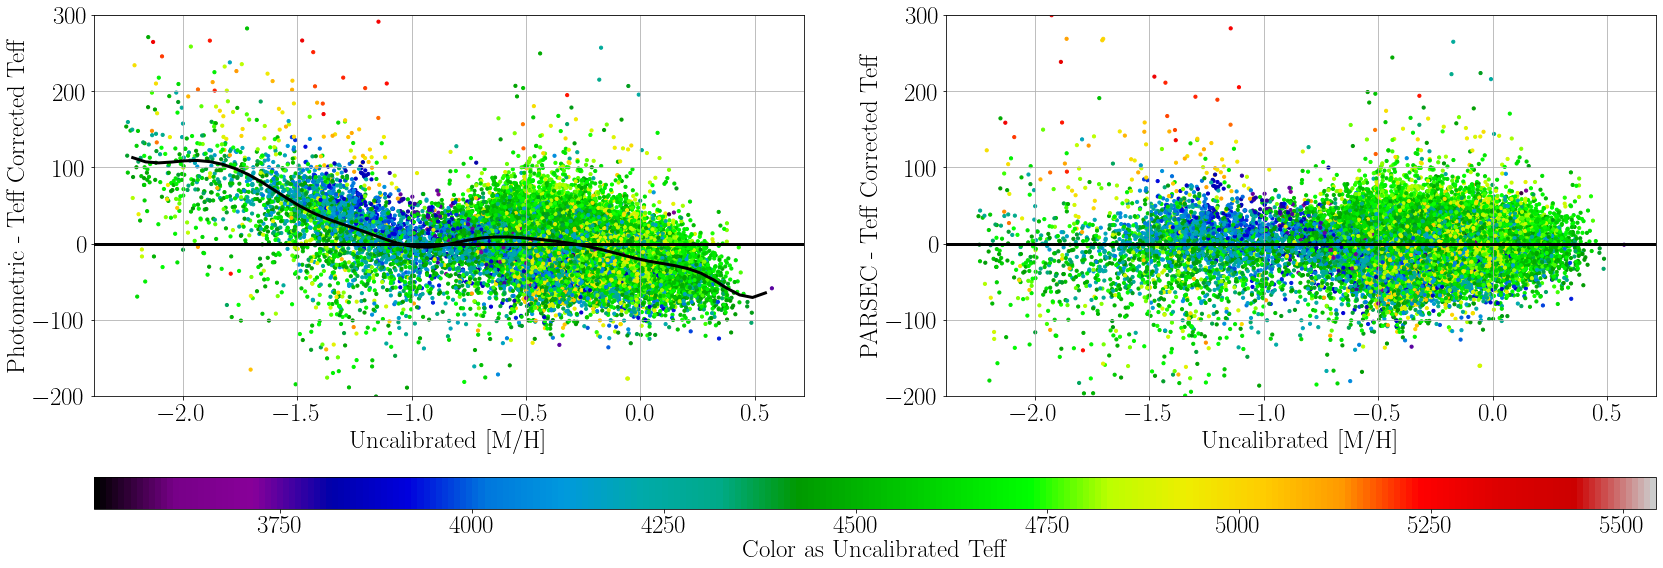

In [35]:
### Binned
fig,ax = plt.subplots(1,2,figsize=[28,10])

ax[0].scatter(low_ext_rgb['FPARAM'][:,3],
              (pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])),
              c=low_ext_rgb['FPARAM'][:,0],cmap='nipy_spectral',s=10)

ax[0].plot(censpmh[finpmh2],mcal_bin_spl(censpmh[finpmh2]),c='k',lw=3.0)
ax[0].axhline(0.0,c='k',lw=3.0)
ax[0].set_ylim(-200,300)
ax[0].grid()
ax[0].set_xlabel(r'Uncalibrated [M/H]')
ax[0].set_ylabel(r'Photometric - Teff Corrected Teff')

im = ax[1].scatter(low_ext_rgb['FPARAM'][:,3],
            pteff['PHOTTEFF']-(tcal_bin_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])-
            (mcal_bin_spl(low_ext_rgb['FPARAM'][:,3])),
            c=low_ext_rgb['FPARAM'][:,0],s=10,cmap='nipy_spectral')

ax[1].axhline(0.0,c='k',lw=3.0)
ax[1].set_ylim(-200,300)
ax[1].grid()
ax[1].set_xlabel(r'Uncalibrated [M/H]')
ax[1].set_ylabel(r'PARSEC - Teff Corrected Teff')

cbar = fig.colorbar(im,orientation='horizontal',aspect=50,ax=ax.ravel().tolist())
cbar.set_label('Color as Uncalibrated Teff',labelpad=1)

plt.savefig('../plots/teff_teff_mh_bin_spline.png',dpi=300,bbox_inches='tight')
plt.show()

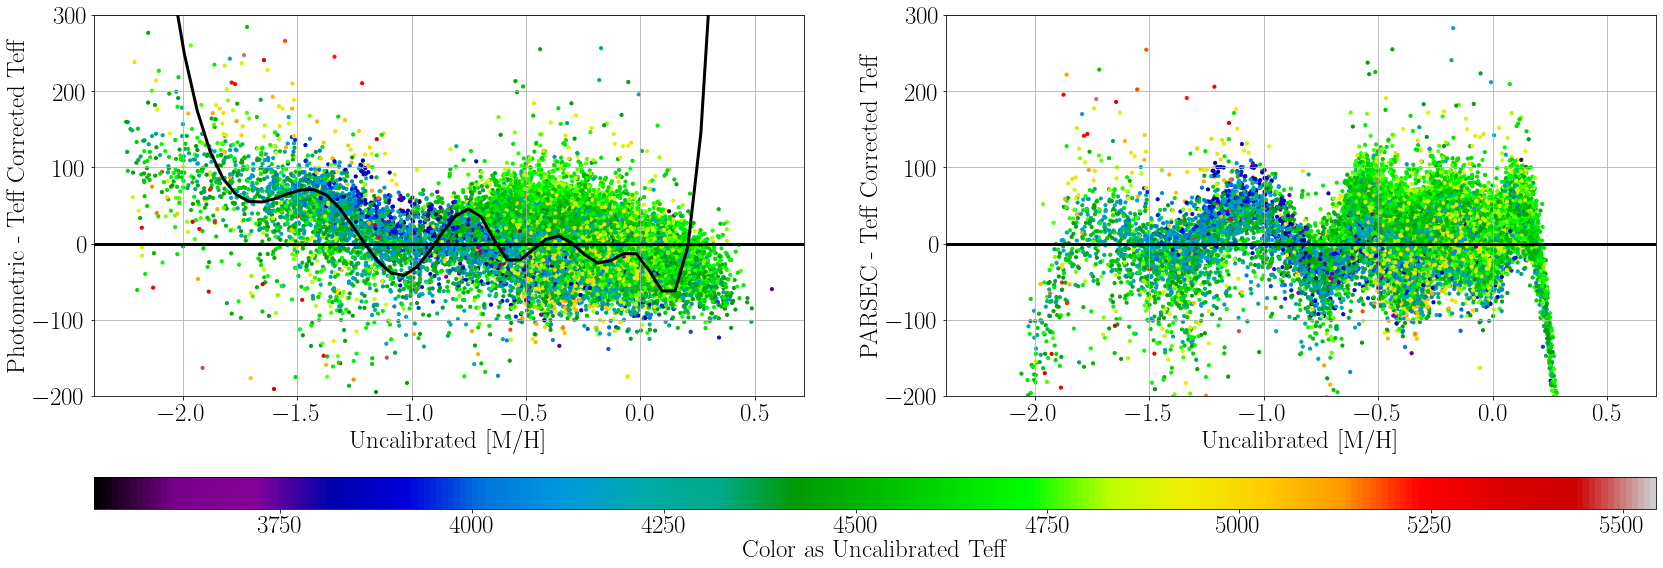

In [34]:
### Individual
fig,ax = plt.subplots(1,2,figsize=[28,10])

ax[0].scatter(low_ext_rgb['FPARAM'][:,3],
              (pteff['PHOTTEFF']-(tcal_ind_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])),
              c=low_ext_rgb['FPARAM'][:,0],cmap='nipy_spectral',s=10)

ax[0].plot(censpmh[finpmh2],mcal_ind_spl(censpmh[finpmh2]),c='k',lw=3.0)
ax[0].axhline(0.0,c='k',lw=3.0)
ax[0].set_ylim(-200,300)
ax[0].grid()
ax[0].set_xlabel(r'Uncalibrated [M/H]')
ax[0].set_ylabel(r'Photometric - Teff Corrected Teff')

im = ax[1].scatter(low_ext_rgb['FPARAM'][:,3],
            pteff['PHOTTEFF']-(tcal_ind_spl(low_ext_rgb['FPARAM'][:,0])+low_ext_rgb['FPARAM'][:,0])-
            (mcal_ind_spl(low_ext_rgb['FPARAM'][:,3])),
            c=low_ext_rgb['FPARAM'][:,0],s=10,cmap='nipy_spectral')

ax[1].axhline(0.0,c='k',lw=3.0)
ax[1].set_ylim(-200,300)
ax[1].grid()
ax[1].set_xlabel(r'Uncalibrated [M/H]')
ax[1].set_ylabel(r'PARSEC - Teff Corrected Teff')

cbar = fig.colorbar(im,orientation='horizontal',aspect=50,ax=ax.ravel().tolist())
cbar.set_label('Color as Uncalibrated Teff',labelpad=1)

plt.savefig('../plots/teff_teff_mh_ind_spline.pdf',dpi=300,bbox_inches='tight')
plt.show()